#### **1. 设置环境**

导入 Python 标准库、第三方库和本项目自定义库

In [1]:
# 标准库
import os
import sys

# 第三方库
# pip install seaborn matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# 将上级目录加入系统路径
# 以便导入项目自定义库
sys.path.append(os.path.abspath('..'))

# 自定义库
# 句法特征分析模块
from src.analyzer.syntax_feature_analysis import SyntaxFeatureAnalyzer

#### **2. 读取数据**

读取包含词性和句法标注的多版本平行语料库

In [2]:
# 指定语料库文件路径 data/output/1_syntax_annotation.jsonl
# 文件为 JSON 格式
# 包含原文和译文的词性和句法特征标注

data_file = '../data/output/1_syntax_annotation.jsonl'
print(f"从 {os.path.abspath(data_file)} 文件读取数据 ...")

# 读取数据 
analyzer = SyntaxFeatureAnalyzer(data_file)
analyzer.load_data()
print(f"读取完成！包含下列版本：{analyzer.versions}\n")

# === PKU 中文词性赋码集 ===
# https://hanlp.hankcs.com/docs/annotations/pos/pku.html

# === Stanford 中文依存关系类别 ===
# https://hanlp.hankcs.com/docs/annotations/dep/sd_zh.html

# === PTB 英文词性赋码集 ===
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

# === UD 英文依存关系类别 ===
# https://universaldependencies.org/u/dep/

print("词性赋码和依存关系示例：\n")
for ver in analyzer.stats.keys():
    if ver in ['source', 'human']:
        print(f'=== {ver} ===')
        for feature_type, feature_distr in analyzer.stats[ver].items():
            if feature_type in ['pos', 'dep']:
                print(f"【{feature_type}】: {feature_distr}")

从 C:\2026_llm_corpus_annotation\data\output\1_syntax_annotation.jsonl 文件读取数据 ...
读取完成！包含下列版本：{'qwen3-max', 'deepseek-v3.2', 'source', 'human'}

词性赋码和依存关系示例：

=== source ===
【pos】: Counter({'w': 1577, 'v': 1533, 'n': 999, 'd': 504, 'r': 472, 'u': 324, 'a': 248, 'nr': 245, 'm': 196, 'p': 172, 'q': 147, 'c': 105, 'f': 103, 'Ng': 88, 'y': 65, 's': 64, 'ns': 52, 't': 45, 'Vg': 40, 'i': 28, 'l': 26, 'z': 20, 'ad': 17, 'Ag': 13, 'Tg': 13, 'vn': 11, 'j': 11, 'nz': 10, 'Dg': 7, 'b': 6, 'o': 6, 'e': 5, 'k': 4, 'an': 2, 'vd': 1})
【dep】: Counter({'dep': 730, 'nsubj': 718, 'advmod': 665, 'dobj': 441, 'conj': 402, 'nn': 353, 'root': 345, 'ccomp': 246, 'nummod': 164, 'prep': 139, 'asp': 133, 'amod': 131, 'det': 110, 'pobj': 92, 'clf': 88, 'mmod': 81, 'assm': 77, 'assmod': 74, 'lobj': 72, 'attr': 62, 'cpm': 57, 'rcomp': 49, 'rcmod': 42, 'neg': 37, 'plmod': 37, 'loc': 36, 'top': 34, 'ba': 30, 'cc': 22, 'range': 20, 'comod': 16, 'tmod': 16, 'prtmod': 14, 'cop': 13, 'lccomp': 12, 'pccomp': 9, 'pass': 5, 

#### **3. 分析数据**

统计各版本译文中的词性和句法特征分布

In [3]:
# ==== 词性赋码分布 ====

# 指定词类
# 每个词类可匹配多个标签
# 如 ["NN"] 匹配 NN，NNS，NNP 和 NNPS
pos_config = {
    "名词 (NN)": ["NN"],
    "动词 (VB)": ["VB"],
    "形容词 (JJ)": ["JJ"],
    "代词 (PRP)": ["PRP"],
    "介词 (IN)": ["IN"],
}

# 统计指定词类占比
df_pos = analyzer.get_feature_report(
    feature_type='pos', 
    target_tags_map=pos_config,
)

# 预览统计结果
df_pos[df_pos["Feature Label"] == "名词 (NN)"]

,Version,Feature Label,Count,Percentage
0,qwen3-max,名词 (NN),2015,20.980841
5,deepseek-v3.2,名词 (NN),2039,21.357495
10,human,名词 (NN),1807,17.455564


In [4]:
# === 句法关系分布 ===

# 指定句法结构
# 每个结构可匹配多个标签
# 如 ["pass"] 匹配 nsubj:pass，aux:pass 和 csubj:pass
dep_config = {
    "被动语态 (Passive)": ["pass"],
    "名词修饰/复合 (Compound)": ["compound", "flat"],
    "从句结构 (Clause)": ["advcl", "ccomp", "acl"],
    "并列结构 (Coordination)": ["conj", "cc"],
    "定语/修饰 (Modifier)": ["amod", "advmod"]
}

# 统计指定结构占比
df_dep = analyzer.get_feature_report(
    feature_type='dep', 
    target_tags_map=dep_config,
)

# 预览统计结果
df_dep[df_dep["Feature Label"] == "并列结构 (Coordination)"]

,Version,Feature Label,Count,Percentage
3,qwen3-max,并列结构 (Coordination),895,11.031678
8,deepseek-v3.2,并列结构 (Coordination),842,10.449243
13,human,并列结构 (Coordination),722,8.243891


#### **4. 绘制图表**

绘制柱状图，展示各译本中的词性/句法特征分布

In [5]:
# 设置绘图风格
font_name = 'Microsoft YaHei'
sns.set_theme(style="white", font=font_name) 

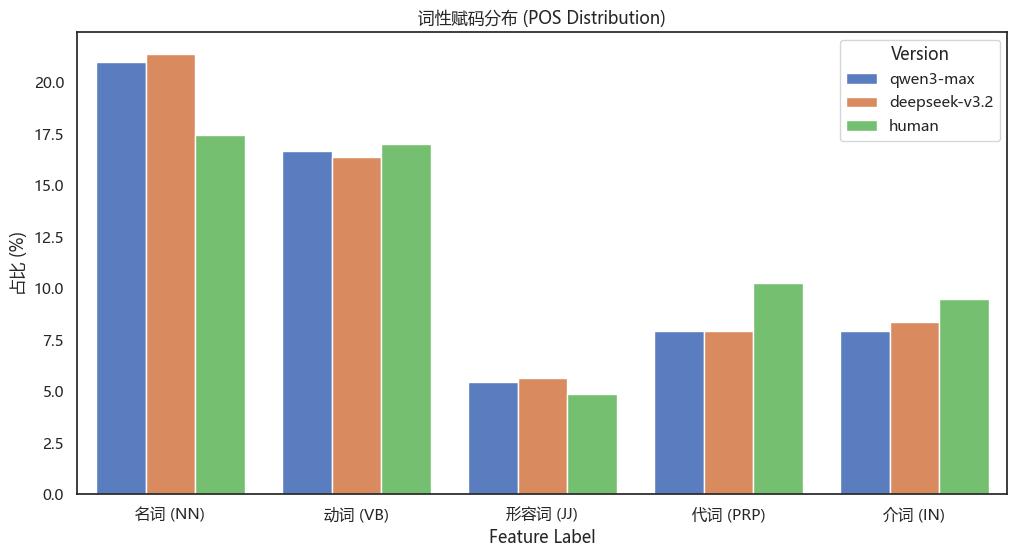

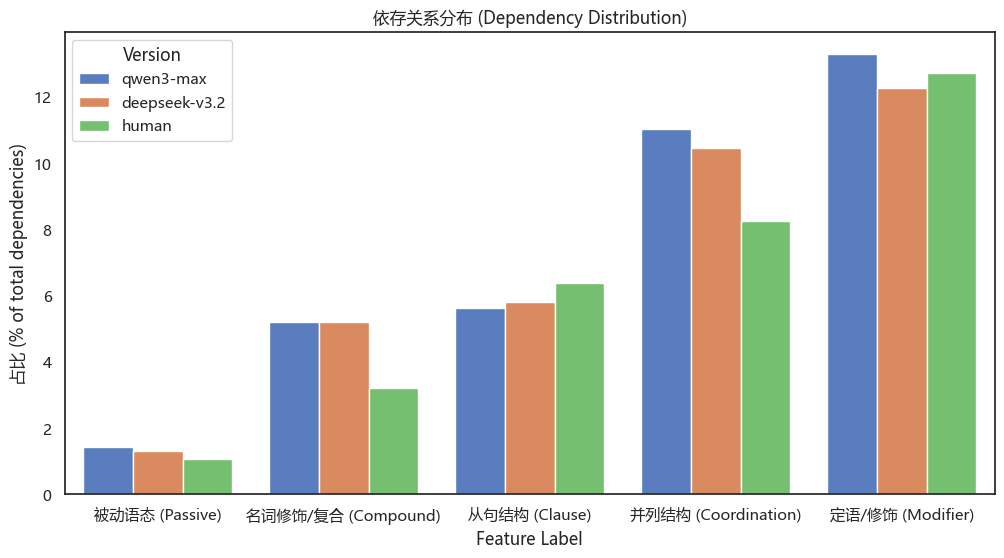

In [6]:
# --- 图 1: 词性赋码分布 ---
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature Label", y="Percentage", hue="Version", data=df_pos, palette="muted")
plt.title("词性赋码分布 (POS Distribution)")
plt.ylabel("占比 (%)")
plt.show()

#display(df_pos.pivot(index="Feature Label", columns="Version", values="Percentage").round(2))

# --- 图 2: 句法关系分布 ---
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature Label", y="Percentage", hue="Version", data=df_dep, palette="muted")
plt.title("依存关系分布 (Dependency Distribution)")
plt.ylabel("占比 (% of total dependencies)")
plt.show()

#display(df_dep.pivot(index="Feature Label", columns="Version", values="Percentage").round(2))

#### **5. 提取例句**

提取机器译文和人工译文之间句法特征差异最大的例句

In [12]:
# === 重新运行 ===
# 这里的 INPUT_FILE 应该是你 Notebook 里定义好的路径
# INPUT_FILE = '../data/1_syntax_output/mac_multiver_syntax.jsonl'

results = analyzer.get_divergent_examples(
    data_file,
    feature_type='pos',
    target_tags=['PRP'], 
    ver_a='human',       
    ver_b='deepseek-v3.2',               
    min_diff=3
)

print(f"\n共找到 {len(results)} 个典型案例。展示 Top 5:\n")

for i, res in enumerate(results[:10]):
    print(f"[{i+1}] ID: {res['id']} (Diff: +{res['diff']})")
    print(f"原文: {res['source']}")
    print("-" * 70)
    print(f"🤖 Machine (Count: {res['ver_a_count']}):")
    print(f"   Text: {res['ver_a_text']}")
    print(f"   Keywords: {res['ver_a_keys']}")
    print("-" * 70)
    print(f"🧑 Human   (Count: {res['ver_b_count']}):")
    print(f"   Text: {res['ver_b_text']}")
    print(f"   Keywords: {res['ver_b_keys']}")
    print("=" * 70 + "\n")


共找到 62 个典型案例。展示 Top 5:

[1] ID: 000070 (Diff: +10)
原文: “清风、明月”这两句诗，讥刺满清，怀念前明， 虽然不敢刊行，但在志同道合的朋辈之间传诵已遍，此刻顾炎武又读了出来。
----------------------------------------------------------------------
🤖 Machine (Count: 15):
   Text: Gu Yanwu's enthusiasm for Lü's somewhat pedestrian couplet sprang from the fact that it contained a hidden message. In Chinese the word for 'cool' is qing (the word chosen by the Manchus for their new 'Chinese' dynasty) and the word for 'bright' is ming (the name of the old Chinese dynasty they had supplanted). So the couplet Gu had recited could be understood to mean: The Qing wind sways not me, howe'er it blow; For me the Ming moon still shines everywhere. In other words, 'I will never bow to the Manchus, however they may threaten and cajole. For me the Empire is still the Ming Empire, whose loyal subject I remain.' Although the poem in which these lines occurred could not be published, they were familiar to all the like-minded scholars of Lü's wide acquaintance, and Hua

In [8]:
s1 = [['a', 'b'], ['c', 'd']]
s2 = [['e', 'f'], ['g', 'h']]

In [9]:
for tokens, deps in zip (s1, s2):
    print(tokens)

['a', 'b']
['c', 'd']


In [11]:
list(zip (s1, s2))

[(['a', 'b'], ['e', 'f']), (['c', 'd'], ['g', 'h'])]

In [12]:
l = []

In [14]:
l.append({'c'}({'d'}))

<>:1: SyntaxWarning: 'set' object is not callable; perhaps you missed a comma?
<>:1: SyntaxWarning: 'set' object is not callable; perhaps you missed a comma?
C:\Users\zhumi\AppData\Local\Temp\ipykernel_23212\2964518005.py:1: SyntaxWarning: 'set' object is not callable; perhaps you missed a comma?
  l.append({'c'}({'d'}))


TypeError: 'set' object is not callable